# Decision Trees
This notebook is designed to make an initial exploration of decision trees.  It will use the week 3 loan dataset.

Data is from week 3 coursera course.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
loans = pd.read_csv("./lending-club-data.csv", dtype={'next_pymnt_d':str, 'desc':str})

Format the target column to reflect safe as 1 and a risky loan as -1.

In [3]:
loans['target'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

Split the data in train_raw and test_raw set

In [4]:
train_raw, test_raw = train_test_split(loans, test_size=0.2, random_state=1)

Display the percentage of risky and safe loans.

In [5]:
percent_safe_raw = train_raw[train_raw['target'] == 1].size / (1.0 * train_raw.size) * 100
percent_risky_raw = train_raw[train_raw['target'] == -1].size / (1.0 * train_raw.size) * 100

print('Safe: {0:.2f}%'.format(percent_safe_raw))
print('Risky: {0:.2f}%'.format(percent_risky_raw))
print('Size of training set: {0}'.format(len(train_raw.index)))

Safe: 81.16%
Risky: 18.84%
Size of training set: 98085


# Effect of Unbalanced data
If there is a class inbalance, there is a chance that it will bias what the majority class will be.  This section explores this concept and shows class imbalance would affect feature selection.

Compute classification error for a feature.

In [6]:
def classification_error(data, feat='', target='target', Verbose=False):
    '''Calculates classification error
    
    Loops through each catagory in the feature and calculates the 
    classification error.  If the feature name is empty, the method
    calculates the classification error of the local root.
    
    Args:
        feat (str): Catagorical variable name or the empty string
        target (str): associated data should be binary
        
    Returns
        float: The classification error.
    '''
    if feat is '': # Root
        num_pos = len(data[data[target] == 1].index)
        num_neg = len(data[data[target] == -1].index)
        if num_pos > num_neg:
            return num_neg / float(len(data.index))
        else:
            return num_pos / float(len(data.index))
    else: # Not the root
        num_error = 0

        bins = data[feat].unique()
        for value in bins.tolist():
            data_in_bin = data[data[feat] == value]
            num_pos = len(data_in_bin[data_in_bin[target] == 1].index)
            num_neg = len(data_in_bin[data_in_bin[target] == -1].index)
            if Verbose:
                print('In feature', value)
                print('Safe: {0:.2f}% with {1} total'.format(num_pos/ float(len(data_in_bin.index)) * 100, num_pos))
                print('Risky: {0:.2f}% with {1} total'.format(num_neg / float(len(data_in_bin.index)) * 100, num_neg))
                print('-------------------')
            if num_pos > num_neg:
                num_error += num_neg
            else:
                num_error += num_pos

        return num_error / float(len(data.index))

For each feature, print the percentage of risky vs safe loans and the classification error for the feature.  Since there is a class imbalance, the classifiction error is the same as the root without any features added even though this is an unlikely senario.

In [7]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
for feature in features:
    print('--------{0}----------'.format(feature))
    print(classification_error(train_raw, feature, 'target', Verbose=True))

--------grade----------
('In feature', 'B')
Safe: 85.38% with 25383 total
Risky: 14.62% with 4346 total
-------------------
('In feature', 'C')
Safe: 79.45% with 19069 total
Risky: 20.55% with 4933 total
-------------------
('In feature', 'A')
Safe: 92.98% with 16631 total
Risky: 7.02% with 1255 total
-------------------
('In feature', 'D')
Safe: 73.20% with 11193 total
Risky: 26.80% with 4098 total
-------------------
('In feature', 'E')
Safe: 68.20% with 4916 total
Risky: 31.80% with 2292 total
-------------------
('In feature', 'F')
Safe: 60.98% with 1896 total
Risky: 39.02% with 1213 total
-------------------
('In feature', 'G')
Safe: 60.00% with 516 total
Risky: 40.00% with 344 total
-------------------
0.188418208697
--------term----------
('In feature', ' 36 months')
Safe: 84.01% with 65733 total
Risky: 15.99% with 12510 total
-------------------
('In feature', ' 60 months')
Safe: 69.91% with 13871 total
Risky: 30.09% with 5971 total
-------------------
0.188418208697
--------ho

We will use a simple method to balance the class.  We will remove rows from the majority class till the classes are balanced.

In [8]:
percentage_to_remove = 1 - (percent_risky_raw / percent_safe_raw)
train_raw_safe = train_raw[train_raw['target'] == 1]

print("Removing {0:.2f}% of the safe set".format(percentage_to_remove*100))

# Ignore the returned test split
train_safe,_ = train_test_split(train_raw_safe, test_size=percentage_to_remove, random_state=1)

# Combine reduced safe set with raw risky set
train = pd.concat([train_safe, train_raw[train_raw['target'] == -1]])

percent_safe = train[train['target'] == 1].size / (1.0 * train.size) * 100
percent_risky = train[train['target'] == -1].size / (1.0 * train.size) * 100

print("Removed {0} items".format(len(train_raw.index)-len(train.index)))
print('Safe: {0:.2f}%'.format(percent_safe))
print('Risky: {0:.2f}%'.format(percent_risky))
print('Size of new training set: {0}'.format(len(train.index)))

Removing 76.78% of the safe set
Removed 61123 items
Safe: 50.00%
Risky: 50.00%
Size of new training set: 36962


Now if we run for classification error again we get better results

In [9]:
for feature in features:
    print('--------{0}----------'.format(feature))
    print(classification_error(train, feature, 'target'))

--------grade----------
0.386829717007
--------term----------
0.423597207943
--------home_ownership----------
0.47251230994
--------emp_length----------
0.485552729831


# Building the tree

In [10]:
def majority_class(data, target):
    num_pos = len(data[data[target] == 1].index)
    num_neg = len(data[data[target] == -1].index)
    if num_pos > num_neg:
        return 1
    else:
        return -1

In [11]:
def next_feature(data, features, target):
    '''Performs a single step of feature seletion.
    
    Args:
        data (DataFrame)
        features (array_like): list of features referencing columns in the data
        target (str): name of target column in the data
    
    Note:
        Data target must be a binary catagory where positive is 1 and
        negative is -1.
        
    Todo:
        Add support for non binary classification.
        
    Returns:
        str: The name of feature with the lowest classification error
            or None if the root has the lowest classification error.
    '''
    error = pd.DataFrame([[classification_error(data), 'root']], columns=['error', 'feat'])

    for f in features:
        error = error.append(pd.DataFrame([[classification_error(data, f, target), f]]
                                         , columns=['error', 'feat']),
                            ignore_index=True)
    
    lowest_error = error.loc[error['error'].idxmin(0)]
    
    if lowest_error['feat'] is 'root':
        return None
    else:
        return lowest_error['feat']


To ease this process, we define a class to represent a node in the tree.

In [12]:
class Tree(object):
    def __init__(self, feature=None, branches=None, strongest_feature_value=None, 
                 is_leaf=False, result=None):
        self.is_leaf = is_leaf
        self.result = result
        self.feature = feature
        self.branches = branches
        self.strongest_feature_value = strongest_feature_value
    
    def __repr__(self):
        return '(Tree - leaf: {0} - result: {1} - feature: {2})'.format(self.is_leaf,
                                                        self.result, self. feature)

## Missing values
When building the tree, as the tree depth increases, the data used to build the subtrees is reduced.  If the number of unique values for a feature is unbalanced this could be problematic because as the depth increases, so does that one of the values will be removed.  Thus, if a prediction has this value for the feature, there will be a `KeyError` if the item hits a node without the feature value.  To remedy this problem, each node with store the value of the feature with the lowest classification error and the the prediction will fall back to this value when traversing the tree.  

**Note**: This method reduces the accuracy of the prediction but the tradeoff is that the model is more robust.

In [13]:
def build_tree(data, features, target, depth, last_feature=None):
    '''Recursively builds binary decision tree
    
    Args:
        data (DataFrame): Sample and feature data.
        features (array_like): List of names of features that map to
            columns in the data.
        target (str): Name of target column in data.
        depth (int): Maximum depth of tree.
        
    Note:
        Target data is assumes to be of the form 1 or -1. This method
        buuilds a binary decision tree not a binary tree.
        
    Returns:
        Tree: The root node of the binary decision tree.
    '''
    current_feature = next_feature(data, features, target)

    #print('last: {0} --- current: {1} -- Same: {2}'.format(
    #    last_feature, current_feature, last_feature == current_feature))
    
    # Leaf node
    if depth == 0 or current_feature is None or current_feature == last_feature:
        #print('Leaf ----->>> last: {0} --- current: {1} -- Same: {2}'.format(
        #    last_feature, current_feature, last_feature == current_feature))
        return Tree(is_leaf=True, result=majority_class(data, target))
    
    depth -= 1
    bins = data[current_feature].unique()
    strongest_feature_value = data[current_feature].value_counts().index[0]
    node = Tree(feature=current_feature, branches={}, 
                strongest_feature_value=strongest_feature_value)
    for val in bins:
        node.branches[val] = build_tree(data[data[current_feature] == val], 
                                        features, target, depth,
                                        last_feature=current_feature)
    
    return node

For simplicity, we will build a model using the 4 features we previously defined and a depth of 6. 

In [14]:
simple_model = build_tree(train, features, 'target', 6)

# Predicting a loan application

In [15]:
def traverse(data, node):
    if node.is_leaf:
        return node.result
    #print('Entering {0} : {1} : {2}'.format(node.feature, data[node.feature], [key for key,value in node.branches.iteritems()]))
    if data[node.feature] in node.branches: 
        next_node = node.branches[data[node.feature]]
    else: # Default to value with lowest classification error if value missing
        next_node = node.branches[node.strongest_feature_value]
    return traverse(data, next_node)

def predict(model, data):
    '''Predicts whether a binary classifaction using decision tree
    
    Args:
        model (Tree): Decision tree.
        data (Dataframe): Items to predict.
    
    Returns:
        ndarray: Predictions of either 1 or -1. 
    '''
    return data.apply(lambda x: traverse(x, model), axis=1).as_matrix()

First we extract the true results from the training set and use the model to make equivalent predictions.

In [16]:
train_output = train['target'].as_matrix()
train_predictions = predict(simple_model, train)

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# total examples}}
$$

First calcuate classification error on the training set.

In [17]:
train_num_error = len(train_output) - np.count_nonzero(train_output + train_predictions)
error_simple_train = train_num_error/float(len(train_output))* 100

print('Classification error: {0:.2f}%'.format(error_simple_train))

Classification error: 37.56%


Now calculate the classification error of the model on the test set.

In [18]:
test_output = test_raw['target'].as_matrix()
test_predictions = predict(simple_model, test_raw)

test_num_error = len(test_output) - np.count_nonzero(test_output + test_predictions)
error_simple_test = test_num_error/float(len(test_output))* 100

print('Classification error: {0:.2f}%'.format(error_simple_test))

Classification error: 40.69%


# Adding more features
We will perform the same operations on the same data set but with a greater set of features to see what the effect is on classification error.

In [19]:
large_features = ['grade',                     # grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
           ]

In [20]:
for f in large_features:
    print('{0}: {1}'.format(f, len(train[f].unique())))

grade: 7
short_emp: 2
emp_length_num: 12
home_ownership: 4
purpose: 12
term: 2
last_delinq_none: 2
last_major_derog_none: 2


**Note**: This may take awhile.

In [21]:
large_model = build_tree(train, large_features, 'target', 9)

Classification error on training set

In [22]:
train_predictions_large = predict(large_model, train)
train_num_error_large = len(train_output) - np.count_nonzero(train_output + train_predictions_large)
error_large_train = train_num_error_large/float(len(train_output))* 100

print('Classification error: {0:.2f}%'.format(error_large_train))

Classification error: 35.30%


Classification error on the test set

In [23]:
test_predictions_large = predict(large_model, test_raw)
test_num_error_large = len(test_output) - np.count_nonzero(test_output + test_predictions_large)
error_large_test = test_num_error_large/float(len(test_output))* 100

print('Classification error: {0:.2f}%'.format(error_large_test))

Classification error: 42.91%


Compare the difference between the simple model and the complex model with the larger depth and feature set.

In [24]:
print('Difference between simple and complex training: {0:.2f}'.format(
    error_simple_train-error_large_train))
print('Difference between simple and complex test: {0:.2f}'.format(
    error_simple_test-error_large_test))

Difference between simple and complex training: 2.26
Difference between simple and complex test: -2.22


The training error was reduced by using the complex model but test error increased.  This is an indication that overfitting may be present.

# Exploring overfitting
We will see if we can replicate the overfitting model.

First we will create a wrapper to predict error.

In [25]:
def get_errors(data_train, data_test, features, depth):
    '''Not generalizable so values are hard coded'''
    model = build_tree(data_train, features, 'target', depth)
    
    train_output = data_train['target'].as_matrix()
    test_output = data_test['target'].as_matrix()
    
    # train
    train_p = predict(model, data_train)
    train_num_e = len(train_output) - np.count_nonzero(train_output + train_p)
    train_e = train_num_e/float(len(train_output))* 100
    
    # test 
    test_p = predict(model, data_test)
    test_num_e = len(test_output) - np.count_nonzero(test_output + test_p)
    test_e = test_num_e/float(len(test_output))* 100
    
    return train_e, test_e

Using the large feature set, we see that the behavior we expect is replicated.  This is using our large feature set.  

**Note**:

We would not do this in a real application though because we are optimizing over out test set.  This would happen on a validation set.

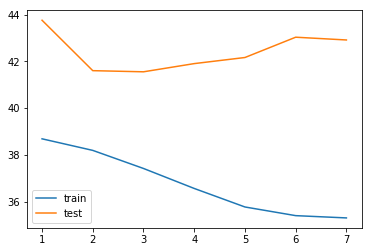

In [32]:
depth = np.arange(1, 8, 1)
train_errors = np.array([])
test_errors = np.array([])

for d in depth:
    t1, t2 = get_errors(train, test_raw, large_features, d)
    train_errors = np.append(train_errors, t1)
    test_errors = np.append(test_errors, t2)
    
plt.plot(depth, train_errors, label='train')
plt.plot(depth, test_errors, label='test')
plt.legend()
plt.show()

Using the small feature set.

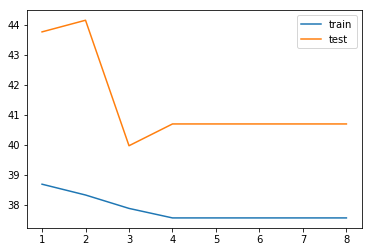

In [34]:
depth = np.arange(1, 9, 1)
train_errors = np.array([])
test_errors = np.array([])

for d in depth:
    t1, t2 = get_errors(train, test_raw, features, d)
    train_errors = np.append(train_errors, t1)
    test_errors = np.append(test_errors, t2)
    
plt.plot(depth, train_errors, label='train')
plt.plot(depth, test_errors, label='test')
plt.legend()
plt.show()